# CHAPTER 10 디지털 오일필드와 딥러닝



In [13]:
import numpy as np
import tensorflow as tf
import pandas as pd
seed = 10
def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## 2.3 딥러닝을 사용한 셰일가스 생산자료 분석

In [3]:
df = pd.read_csv('./Data/ShaleGasData.csv', header=0)
df.head()

,Well_ID,X,Y,TVD,CompLength,FracStage,TotalPropPlaced,qi,b,D,CumProd
0,1,-560.508644,351.142295,3573.0,1173.0,11,1225.100002,2131.759129,1.601106,1.047887,26290.048707
1,2,-517.735644,403.380295,3534.2,1103.5,12,1088.530019,1202.730372,1.668195,0.564643,21994.549200
2,3,-460.299644,375.845295,3562.0,1056.0,8,823.029999,1192.138061,1.472837,0.215471,33662.097284
3,4,-391.097644,377.597295,3402.0,2081.5,19,3107.400011,7257.215263,1.520000,0.200000,241380.762966
4,5,-389.422644,400.967295,3637.0,1617.5,17,2391.350006,2498.639839,2.000000,0.673566,59391.723657


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 11 columns):
Well_ID            132 non-null int64
X                  132 non-null float64
Y                  132 non-null float64
TVD                132 non-null float64
CompLength         132 non-null float64
FracStage          132 non-null int64
TotalPropPlaced    132 non-null float64
qi                 132 non-null float64
b                  132 non-null float64
D                  132 non-null float64
CumProd            132 non-null float64
dtypes: float64(9), int64(2)
memory usage: 11.4 KB


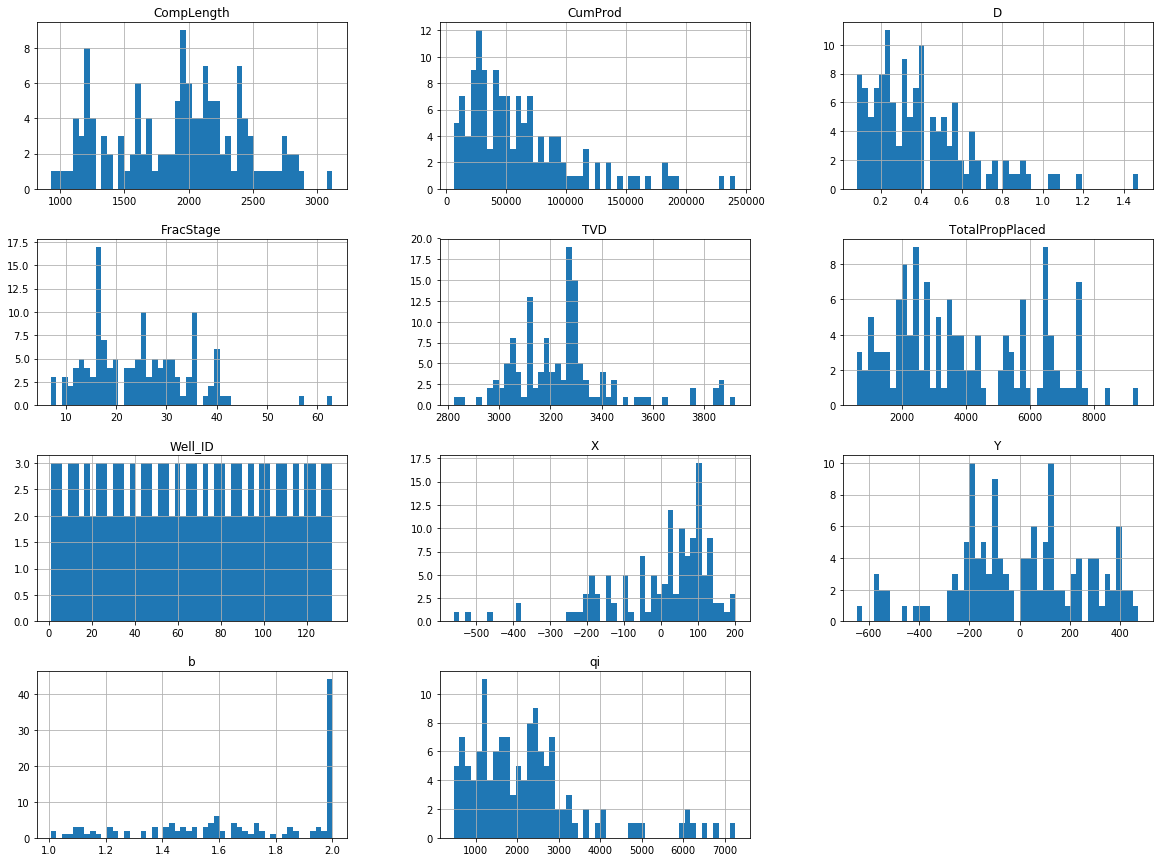

In [5]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

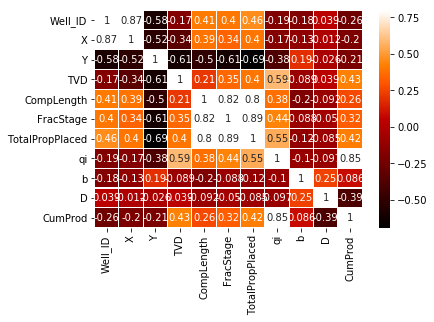

In [11]:
import seaborn as sns
sns.heatmap(df.corr(), linewidths=0.1, vmax=0.8, cmap=plt.cm.gist_heat, linecolor='white', annot=True)

#### 훈련/검증 데이터세트 분리

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size = 0.15, random_state=seed)
train_set, val_set = train_test_split(train_set, test_size = 0.15, random_state=seed)

In [15]:
X_attributes = ['X','Y','TVD','CompLength','FracStage','TotalPropPlaced']
y_attributes = ['qi']

X_train = train_set[X_attributes].values
y_train = train_set[y_attributes].values

X_val = val_set[X_attributes].values
y_val = val_set[y_attributes].values

X_test = test_set[X_attributes].values
y_test = test_set[y_attributes].values

#### 특성 스케일링

In [16]:
from sklearn.preprocessing import MinMaxScaler

X_scaler =MinMaxScaler()
y_scaler =MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train) 
y_train_scaled = y_scaler.fit_transform(y_train) 

X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

#### 신경망 구성

In [18]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def check(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('Stop.... Condition for early stopping is satisfied!')
                return 1
            return 0
        else:
            self._step = 0
            self._loss = loss
            return 2

In [19]:
n_inputs = 6 
n_hidden1 = 30
n_hidden2 = 20
n_hidden3 = 10
n_outputs = 1


learning_rate=0.003

from datetime import datetime
now = datetime.utcnow().strftime("%d%H%M%S")
root_logdir = 'logs'
ckpt_name = '{}-{}-{}-{}'.format(n_hidden1, n_hidden2, n_hidden3, 'relu')
train_logdir = '{}/train-{}-{}'.format(root_logdir, ckpt_name, now)
val_logdir = '{}/val-{}-{}'.format(root_logdir, ckpt_name, now)

reset_graph()


X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu)
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu)
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu)
logits = tf.layers.dense(hidden3, n_outputs) 

loss = tf.losses.mean_squared_error(y, logits)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

loss_summary = tf.summary.scalar('loss', loss)
train_file_writer = tf.summary.FileWriter(train_logdir, tf.get_default_graph())
val_file_writer = tf.summary.FileWriter(val_logdir, tf.get_default_graph())

saver = tf.train.Saver(max_to_keep=1)

In [20]:
n_samples = len(X_train)

def fetch_batch(batch_size, epoch, iteration):
    np.random.seed(epoch)
    shuffled_indices = np.random.permutation(n_samples)
    batch_indices = shuffled_indices[iteration * batch_size:(iteration+1)*batch_size]
    return X_train_scaled[batch_indices, :], y_train_scaled[batch_indices]

In [24]:
early_stopping = EarlyStopping(patience = 200, verbose=1)

n_epochs = 2000
batch_size = 15

init = tf.global_variables_initializer()

lowest_loss = np.float32('inf')
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for iteration in range(n_samples // batch_size):
            X_batch, y_batch = fetch_batch(batch_size, epoch, iteration)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
             
                 
        train_loss, train_summary = sess.run([loss, loss_summary], feed_dict={X: X_batch, y: y_batch})
        val_loss, val_summary = sess.run([loss, loss_summary], feed_dict={X: X_val_scaled, y: y_val_scaled})
            
        if val_loss < lowest_loss:
            save_path = saver.save(sess, "./models/best_model.ckpt")
            lowest_loss = val_loss
        if epoch % 100 == 0: 
            print("Epoch", epoch, "train loss =", train_loss," val loss =", val_loss)    
            train_file_writer.add_summary(train_summary, epoch)
            val_file_writer.add_summary(val_summary, epoch)
        
        if early_stopping.check(val_loss) == 1:
            break

Epoch 0 train loss = 0.023788339  val loss = 0.031436853
Epoch 100 train loss = 0.0043472648  val loss = 0.008465209
Epoch 200 train loss = 0.0037099102  val loss = 0.0073267426
Epoch 300 train loss = 0.0015309165  val loss = 0.009300125
Epoch 400 train loss = 0.0012433969  val loss = 0.009773436
Stop.... Condition for early stopping is satisfied!


#### 학습 결과 확인

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./models/best_model.ckpt")
    y_train_pred = logits.eval(feed_dict={X: X_train_scaled})
    y_val_pred = logits.eval(feed_dict={X: X_val_scaled})   
    y_test_pred = logits.eval(feed_dict={X: X_test_scaled})

INFO:tensorflow:Restoring parameters from ./models/best_model.ckpt


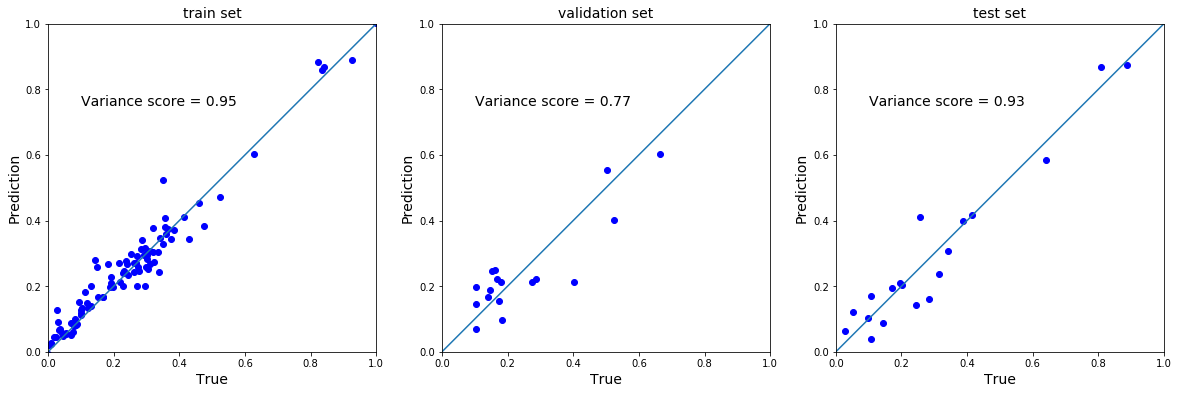

In [26]:
from sklearn.metrics import r2_score
def plot_correlation(t, p, title):    
    plt.scatter(t, p ,color='blue')
    plt.text(0.1,0.75,'Variance score = %.2f'% r2_score(t, p),fontsize = 14)
    plt.plot([0,1],[0,1])
    plt.xlabel('True',fontsize = 14)
    plt.ylabel('Prediction',fontsize = 14)
    plt.gca().set_aspect('equal')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(title, fontsize=14)
    
plt.figure(figsize=(20,10))
plt.subplot(131)
plot_correlation(y_train_scaled, y_train_pred, 'train set')
plt.subplot(132)
plot_correlation(y_val_scaled, y_val_pred, 'validation set')
plt.subplot(133)
plot_correlation(y_test_scaled, y_test_pred, 'test set')

#### 스케일링 된 레이블 재변환

In [27]:
y_train_inversed = y_scaler.inverse_transform(y_train_scaled)
y_train_pred_inversed = y_scaler.inverse_transform(y_train_pred)

y_val_inversed = y_scaler.inverse_transform(y_val_scaled)
y_val_pred_inversed = y_scaler.inverse_transform(y_val_pred)

y_test_inversed = y_scaler.inverse_transform(y_test_scaled)
y_test_pred_inversed = y_scaler.inverse_transform(y_test_pred)

In [28]:
print('Train Variance score :     %.2f' % r2_score(y_train_inversed, y_train_pred_inversed))
print('Validation Variance score: %.2f' % r2_score(y_val_inversed, y_val_pred_inversed))
print('Test Variance score:       %.2f' % r2_score(y_test_inversed, y_test_pred_inversed))

Train Variance score :     0.95
Validation Variance score: 0.77
Test Variance score:       0.93
